In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gdown

In [2]:
# Download the data
# obs: github não armazena arquivos maiores que 100MB

# df = pd.read_csv('https://raw.githubusercontent.com/andrebrum/andrebrum.github.io/master/datasets/air_quality.csv')
# url = "https://drive.usercontent.google.com/uc?id=1GINDasXHcESqGYMX6KuhEGzCZEx71wHg&confirm=t&authuser=0"
# url = "https://drive.google.com/drive/folders/1faDceV4LIHdOhANpuEgh-9otlMgzy2xP?usp=sharing"

# https://drive.google.com/file/d/1GINDasXHcESqGYMX6KuhEGzCZEx71wHg/view?usp=sharing

ID = "1GINDasXHcESqGYMX6KuhEGzCZEx71wHg"
url = f"https://drive.google.com/uc?id={ID}"
print(url)
gdown.download(url, output="raw_data.zip", quiet=False, use_cookies=True)

# output_zipfile = "raw_data.zip"
# gdown.download(url, output=output_zipfile, quiet=False, use_cookies=True)
# gdown.download_folder(url, output="raw_data", quiet=False, use_cookies=True)

import zipfile
with zipfile.ZipFile("raw_data.zip", 'r') as zip_ref:
    zip_ref.extractall("")




https://drive.google.com/uc?id=1GINDasXHcESqGYMX6KuhEGzCZEx71wHg


Downloading...
From (original): https://drive.google.com/uc?id=1GINDasXHcESqGYMX6KuhEGzCZEx71wHg
From (redirected): https://drive.google.com/uc?id=1GINDasXHcESqGYMX6KuhEGzCZEx71wHg&confirm=t&uuid=c709693e-071c-4be2-9a04-314971e6369b
To: /home/adonai/case_elo/raw_data.zip
100%|██████████| 38.3M/38.3M [00:03<00:00, 10.2MB/s]


In [3]:
demographic = pd.read_csv('raw_data/DemographicData_ZCTAs.csv', index_col=0)
geocode = pd.read_csv('raw_data/df_geocode.csv', index_col=0)
economic = pd.read_csv('raw_data/EconomicData_ZCTAs.csv', index_col=0)
exams = pd.read_csv('raw_data/exams_data.csv', index_col=0)
transactional = pd.read_csv('raw_data/transactional_data.csv', index_col=0, sep=';')

In [4]:
from datetime import datetime

# Convert 'Date of birth' to datetime
transactional['Date of birth'] = pd.to_datetime(transactional['Date of birth'], errors='coerce')

# Calculate age
today = datetime.today()
transactional['Age'] = transactional['Date of birth'].apply(lambda dob: today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day)))

# Display the updated DataFrame
transactional[['Date of birth', 'Age']].head()

,Date of birth,Age
Patient Id,,
10210830256-BIO003,1976-01-08,49.0
10210830256-BIO003,1976-01-08,49.0
10210830256-BIO003,1976-01-08,49.0
10210830256-BIO003,1976-01-08,49.0
10210830256-BIO003,1976-01-08,49.0


# Ideias de resolução:

Hipóteses:
- Quero ZCTAs que gerem maior receita. Talvez como segundo critério achar lugares onde o laboratório não está presente para expandir participação no território

- Será que consigo identificar um padrão de quais laboratórios geram maior receita? (desconsiderando outliers)


No cenário de medicina diagnóstica:
- A fidelização é mais importante que a propaganda.


Ideia: 
- fazer algum aprendizado não supervisionado para identificar padrões. 

In [6]:
transactional

,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost,Age
Patient Id,,,,,,,,
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70003237,"9,0",49.0
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000638,"13,0",49.0
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70001597,"49,0",49.0
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000103,"11,0",49.0
10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000224,"10,0",49.0
...,...,...,...,...,...,...,...,...
7664157546-1,M,1971-06-03,2021-02-12,7664157546-1-1,L697,70004038,"10,0",53.0
7664157546-1,M,1971-06-03,2021-02-12,7664157546-1-1,L697,70004134,"10,0",53.0
7664157546-1,M,1971-06-03,2021-02-12,7664157546-1-1,L697,70003056,"9,0",53.0


array([[<Axes: title={'center': 'Date of birth'}>,
        <Axes: title={'center': 'CodItem'}>],
       [<Axes: title={'center': 'Age'}>, <Axes: >]], dtype=object)

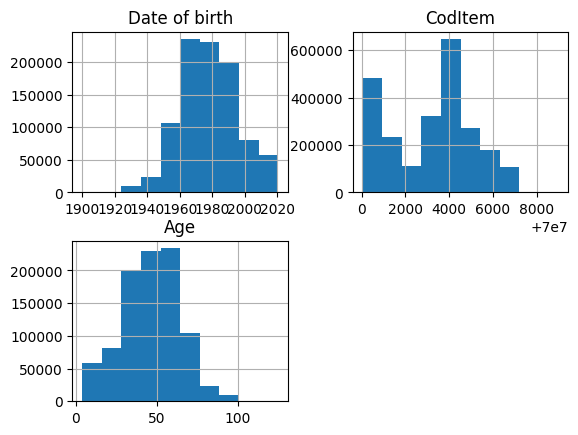

In [5]:
transactional.hist()

In [24]:
# Ensure 'Testing Cost' is numeric
transactional['Testing Cost'] = transactional['Testing Cost'].str.replace(',', '.').astype(float)

# Group by 'Patient Id' and calculate metrics
patient_info = transactional.groupby('Patient Id').agg(
    Number_of_Exams=('CodItem', 'count'),
    Total_Expenditure=('Testing Cost', 'sum'),
    Age=('Age', 'first'),  # Assuming age is consistent for each patient
    Gender=('Gender', 'first')  # Assuming gender is consistent for each patient
).reset_index()

# Display the resulting DataFrame
patient_info.head()

,Patient Id,Number_of_Exams,Total_Expenditure,Age,Gender
0,-2,10,204.0,125.0,I
1,1000007167-1,1,12.0,61.0,F
2,1000007439-1,4,52.0,28.0,F
3,1000014746-1,17,470.0,NaN,M
4,1000025251-1,1,113.0,NaN,F


In [25]:
patient_info

,Patient Id,Number_of_Exams,Total_Expenditure,Age,Gender
0,-2,10,204.00,125.0,I
1,1000007167-1,1,12.00,61.0,F
2,1000007439-1,4,52.00,28.0,F
3,1000014746-1,17,470.00,NaN,M
4,1000025251-1,1,113.00,NaN,F
...,...,...,...,...,...
501441,99958237-BIO003,9,164.00,53.0,M
501442,99974240-BIO010,9,270.00,65.0,F
501443,99999-1,35,4394.00,75.0,M
501444,999999-1,17,8204.00,75.0,F


In [22]:
economic

,id,Geographic Area Name,TotalHouseholds_LessThan$10.000,TotalHouseholds_$10.000to$14.999,TotalHouseholds_$15.000to$24.999,TotalHouseholds_$25.000to$34.999,TotalHouseholds_$35.000to$49.999,TotalHouseholds_$50.000to$74.999,TotalHouseholds_$75.000to$99.999,TotalHouseholds_$100.000to$149.999,TotalHouseholds_$150.000to$199.999,TotalHouseholds_$200.000OrMore
0,8600000US35004,ZCTA5 35004,198,71,298,513,647,1117,529,945,245,61
1,8600000US35005,ZCTA5 35005,188,184,318,293,353,562,299,407,67,26
2,8600000US35006,ZCTA5 35006,71,20,117,104,154,176,124,194,51,7
3,8600000US35007,ZCTA5 35007,396,208,670,462,1173,1854,1578,2224,473,254
4,8600000US35010,ZCTA5 35010,700,610,1093,957,1056,1512,807,749,254,249
...,...,...,...,...,...,...,...,...,...,...,...,...
629275,8600000US00979,ZCTA5 00979,735,471,1547,1374,957,1390,662,643,99,319
629276,8600000US00982,ZCTA5 00982,1299,483,1184,848,1104,657,206,79,34,16
629277,8600000US00983,ZCTA5 00983,2638,1368,2495,1845,1906,1952,511,363,110,96
629278,8600000US00985,ZCTA5 00985,2426,1150,2266,1777,1873,1737,501,395,15,26
